In [1]:
import numpy as np
#import tensorflow as tf
#from tensorflow.python.client import device_lib
import pandas as pd
from zipfile import ZipFile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
#import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
#from skimage import exposure
#from skimage.color import rgb2gray
import platform
import sys
from datetime import datetime
%matplotlib inline

In [2]:
driving = "driving_03"

input_files = []

# read CSV file with steering angle
csvdata = pd.read_csv("./data/" + driving + ".csv", header=None)
#samples = [csvdata.iloc[:, 0].values, csvdata.iloc[:, 3].values]
nlabels = csvdata.shape[0]
samples = csvdata.iloc[:, [1, 3]].values

print(samples.shape)
# duplicate data => it will be fliped
samples = np.append(samples, np.zeros((nlabels,1), np.int), axis=1)
samples = np.concatenate((samples, samples), axis=0)
samples[:nlabels, 2] = 0 # first half
samples[nlabels:, 2] = 1 # second half
print(samples.shape)

# original shape
owidth = 320
oheight = 160

# crop
stripetop = 60
stripebot = 20

def generator(samples, batch_size=32):
    num_samples = len(samples)
    # 
    # Loop forever so the generator never terminates
    #  but it only executes when code calls "next()"
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = './data/'+ driving + '/'+batch_sample[0].split('/')[-1]
                #center_image = cv2.imread(name)
                center_image = mpimg.imread(name, format='jpeg')
                center_angle = float(batch_sample[1])
                
                if batch_sample[2]:
                    # flip image
                    center_image = np.fliplr(center_image)
                    center_angle = -center_angle
                
                # train data
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

# 
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
#print(train_samples)

# Python automatically interprets the function as generator, and WON'T execute it right away
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)
# 
print(train_generator)

(1559, 2)
(3118, 3)
<generator object generator at 0x7f0e7c449e08>


In [3]:
print(len(train_samples))
print(samples[0])

2494
[ '/Users/bgcarvalho/Documents/Personal/pos_nanodegree_SDC/CarND-Term1-P3/data/IMG/left_2017_10_26_21_59_46_236.jpg'
 0.0 0]


continue

Could use sample data (provided) as test:

In [4]:
#testdata = pd.read_csv("./sample-data/driving.csv", header=None)
#y_test = y_test + testdata.iloc[:, 3]


# Model Architecture

The proposed model has 5 convolutional layers and 4 fully connected.

In [5]:
from keras.models import load_model, Sequential
from keras.layers import Dense, Flatten, Conv2D, Lambda, MaxPooling2D, Dropout
from keras.layers import Cropping2D
from keras.callbacks import EarlyStopping
from keras import __version__ as keras_version
import h5py

Using TensorFlow backend.


In [38]:
model = Sequential()

# CROP images
model.add(Cropping2D(cropping=((stripetop, stripebot), (0,0)), input_shape=(oheight, owidth, 3)))

# normalization and mean centering
model.add(Lambda(lambda x: (x / 255.0) - 0.5))

# layer 1 - convolutional
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D())

# layer 2
model.add(Conv2D(100, (3, 3), activation='relu'))
model.add(MaxPooling2D())

# layer 3
model.add(Conv2D(80, (3, 3), activation='relu'))
model.add(MaxPooling2D())

# layer 4
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())

# layer 5
model.add(Conv2D(32, (3, 3), activation='relu'))
#model.add(MaxPooling2D())


model.add(Flatten())


# layer 6
#model.add(Dense(1000))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))

# layer 7
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))

# layer 8
#model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))

# layer 9
model.add(Dense(1))

In [39]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_10 (Cropping2D)   (None, 80, 320, 3)        0         
_________________________________________________________________
lambda_10 (Lambda)           (None, 80, 320, 3)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 78, 318, 128)      3584      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 39, 159, 128)      0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 37, 157, 100)      115300    
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 18, 78, 100)       0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 16, 76, 80)        72080     
__________

In [40]:
ee = 1e-6
cb_earlystop = EarlyStopping(min_delta=ee, patience=3, verbose=1)

# compile model
model.compile(loss='mse', optimizer='adam')

# train
# samples_per_epoch=len(train_samples),
history = model.fit_generator(train_generator, 
                              validation_data=validation_generator,
                              validation_steps=len(validation_samples)/32,
                              steps_per_epoch=len(validation_samples)/32, 
                              epochs=5,
                              verbose=1)
# save to disk
model.save('model.h5')


Epoch 1/5
20/19 [==============================] - 12s - loss: 0.0094 - val_loss: 0.0083
Epoch 2/5
20/19 [==============================] - 12s - loss: 0.0069 - val_loss: 0.0081
Epoch 3/5
20/19 [==============================] - 12s - loss: 0.0084 - val_loss: 0.0077
Epoch 4/5
20/19 [==============================] - 12s - loss: 0.0087 - val_loss: 0.0065
Epoch 5/5
20/19 [==============================] - 12s - loss: 0.0071 - val_loss: 0.0072


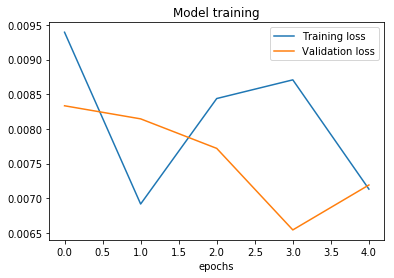

In [41]:
#print(history.history)
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('')
plt.title('Model training')
plt.legend(['Training loss', 'Validation loss'])

## Evaluate

In [ ]:
from keras.models import load_model

In [ ]:
test_generator = generator(test_samples, batch_size=32)

model.load_model('model.h5')
score = model.evaluate_generator(test_generator, batch_size=32)
print(score)